In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-eng
!pip install pytesseract opencv-python scikit-learn transformers datasets joblib

# Data

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/forms/
  inflating: dataset/forms/download (1).jpeg  
  inflating: dataset/forms/download (1).png  
  inflating: dataset/forms/download (2).jpeg  
  inflating: dataset/forms/download (2).png  
  inflating: dataset/forms/download (3).png  
  inflating: dataset/forms/download (4).png  
  inflating: dataset/forms/download.jpeg  
  inflating: dataset/forms/download.png  
  inflating: dataset/forms/image (1).jpg  
  inflating: dataset/forms/image (10).jpg  
  inflating: dataset/forms/image (11).jpg  
  inflating: dataset/forms/image (12).jpg  
  inflating: dataset/forms/image (13).jpg  
  inflating: dataset/forms/image (14).jpg  
  inflating: dataset/forms/image (15).jpg  
  inflating: dataset/forms/image (16).jpg  
  inflating: dataset/forms/image (17).jpg  
  inflating: dataset/forms/image (18).jpg  
  inflating: dataset/forms/image (19).jpg  
  inflating: dataset/forms/image (2).jpg  
  inflating: dataset/forms/image (20).j

# OCR BASED CLASSIFICATION

In [ ]:
import os
import cv2
import pytesseract
import numpy as np
from tqdm import tqdm
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from datasets import Dataset # Import Dataset

# Configure Tesseract executable path for Colab
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


# Step 1: OCR Function
def extract_text(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return pytesseract.image_to_string(thresh).strip()

# Step 2: Load images and labels
def load_dataset(dataset_path):
    texts, labels = [], []
    for label in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir): continue
        for file in tqdm(os.listdir(class_dir), desc=f"Loading {label}"):
            if file.endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(class_dir, file)
                try:
                    text = extract_text(img_path)
                    if text:
                        texts.append(text)
                        labels.append(label)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    return texts, labels

# Step 3: Train model
def train_model(dataset_path):
    texts, labels = load_dataset(dataset_path)
    print(f"Total samples: {len(texts)}")

    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000)),
        ("clf", LinearSVC())
    ])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    print("✅ Classification Report:\n", classification_report(y_test, y_pred))

    joblib.dump(pipeline, "ocr_text_classifier.pkl")
    print("✅ Model saved as 'ocr_text_classifier.pkl'")

    return pipeline, X_test, y_test, y_pred # Return values

if __name__ == "__main__":
    pipeline, X_test, y_test, y_pred = train_model("dataset")  # Unpack returned values

Loading handwritten_notes: 100%|██████████| 53/53 [01:24<00:00,  1.60s/it]

Total samples: 169
✅ Classification Report:
                    precision    recall  f1-score   support

         Invoices       0.57      0.50      0.53         8
        Signature       1.00      0.33      0.50         3
            forms       0.71      0.50      0.59        10
handwritten_notes       0.44      0.89      0.59         9
           resume       1.00      0.25      0.40         4

         accuracy                           0.56        34
        macro avg       0.75      0.49      0.52        34
     weighted avg       0.67      0.56      0.55        34

✅ Model saved as 'ocr_text_classifier.pkl'


start

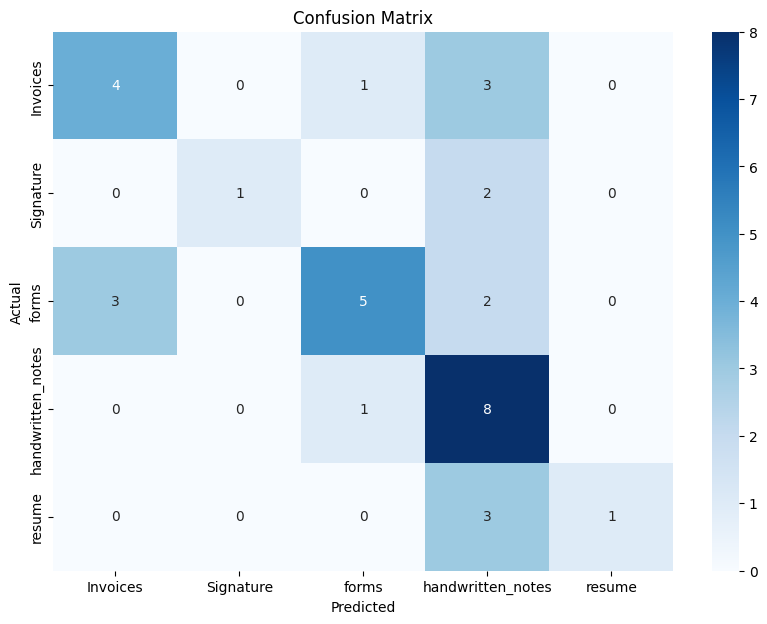

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred are available from the previous training cell
# If not, you would need to re-run the prediction on the test set
# y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

[1] Train Loss: 0.0973, Acc: 0.2979
    Val Loss: 0.0937, Acc: 0.5319
[2] Train Loss: 0.0799, Acc: 0.5798
    Val Loss: 0.0765, Acc: 0.5532
[3] Train Loss: 0.0643, Acc: 0.6915
    Val Loss: 0.0628, Acc: 0.6383
[4] Train Loss: 0.0522, Acc: 0.7394
    Val Loss: 0.0535, Acc: 0.7021
[5] Train Loss: 0.0449, Acc: 0.7606
    Val Loss: 0.0470, Acc: 0.7660
[6] Train Loss: 0.0370, Acc: 0.8085
    Val Loss: 0.0384, Acc: 0.7872
[7] Train Loss: 0.0295, Acc: 0.8670
    Val Loss: 0.0365, Acc: 0.7447
[8] Train Loss: 0.0297, Acc: 0.8085
    Val Loss: 0.0360, Acc: 0.7660
[9] Train Loss: 0.0219, Acc: 0.8989
    Val Loss: 0.0344, Acc: 0.8085
[10] Train Loss: 0.0199, Acc: 0.9043
    Val Loss: 0.0369, Acc: 0.7660
✅ Model saved as 'hybrid_model_trained.pth'


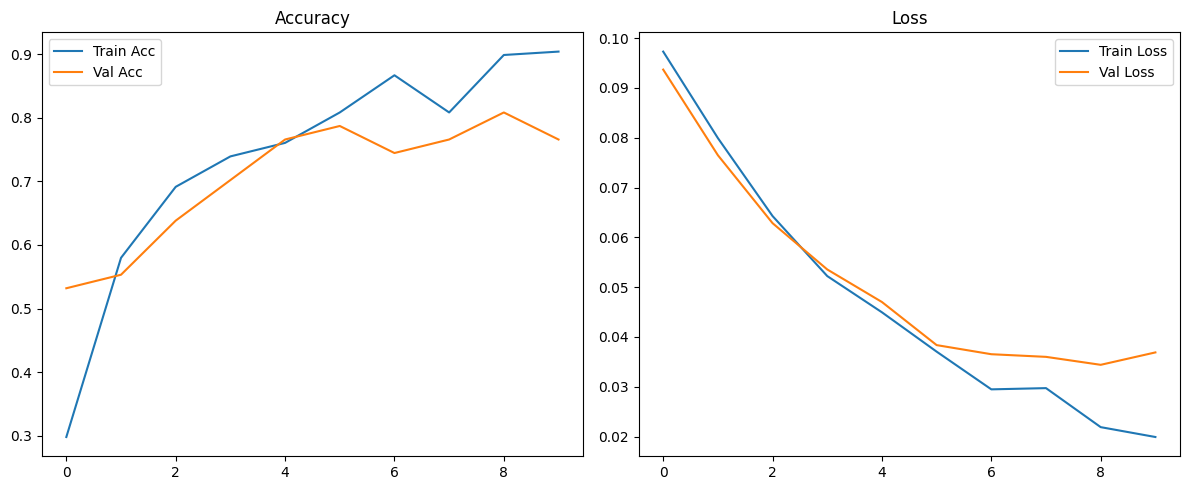

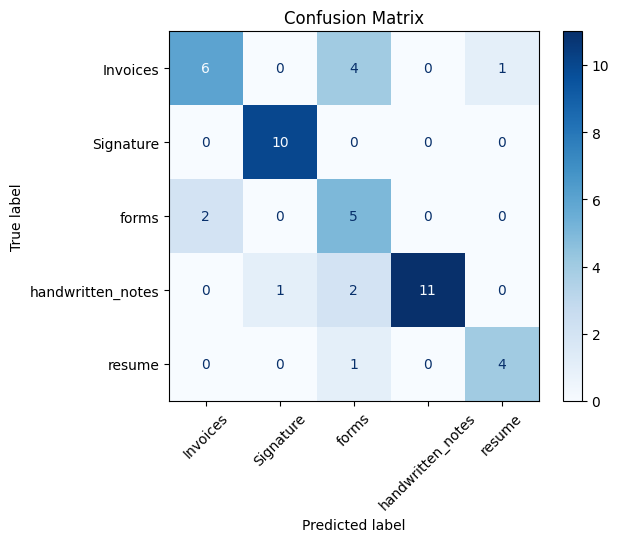

In [ ]:


import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# CONFIG
DATA_DIR = "/content/dataset"
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4
NUM_CLASSES = 5
IMG_SIZE = 384
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  DATASET

import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import random
from PIL import Image, ImageFilter


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

class RandomGaussianBlur(object):
    def __call__(self, img):
        if random.random() < 0.5:
            return img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))
        return img

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BICUBIC),

    # --- Augmentations ---
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # rotate ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # brightness/contrast changes
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    RandomGaussianBlur(),  # Apply blur randomly
    transforms.ToTensor(),
    AddGaussianNoise(mean=0., std=0.02),  # Add noise after converting to tensor

    # --- Normalization for 3-channel pretrained models ---
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
class_names = full_dataset.classes

# Train/Val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

#  MODEL DEFINITION
base_model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

for param in base_model.parameters():
    param.requires_grad = False

for name, param in base_model.features[-1].named_parameters():
    param.requires_grad = True

class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = base_model.features
        self.custom_cnn = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.custom_cnn(x)
        x = self.classifier(x)
        return x

model = HybridModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

# TRAINING LOOP

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    train_loss_history.append(train_loss / total)
    train_acc_history.append(acc)
    print(f"[{epoch+1}] Train Loss: {train_loss/total:.4f}, Acc: {acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    val_loss_history.append(val_loss / val_total)
    val_acc_history.append(val_acc)
    print(f"    Val Loss: {val_loss/val_total:.4f}, Acc: {val_acc:.4f}")

# ------------------------
#  SAVE MODEL
# ------------------------
torch.save(model.state_dict(), "hybrid_model_trained.pth")
print("✅ Model saved as 'hybrid_model_trained.pth'")

# ------------------------
# PLOTS
# ------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(class_names)

['Invoices', 'Signature', 'forms', 'handwritten_notes', 'resume']
